# Exercise 1
### Lars Kuehmichel, Nicolas Wolf

### 1 Loading the Dataset

<span style="color:green;font-weight:bold">
Comment: essentially equal
</span>

In [13]:
from sklearn.datasets import load_digits

digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

import numpy as np
print(data.dtype)


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
float64


In [2]:
threes = target == 3
eights = target == 8

which = threes | eights

bdata = data[which]
btarget = target[which]

bdata = np.append(bdata, np.ones((bdata.shape[0], 1)), axis=-1)

threes = btarget == 3
eights = btarget == 8

# +1 if target[i] == 3, else -1
labels = threes.astype(int) - eights.astype(int)


print(labels.shape)
print(bdata.shape)


(357,)
(357, 65)


<span style="color:green;font-weight:bold">
Comment: We used much more test values for $\lambda$ for a higher accuracy. Additionally, we prefered a $\lambda$ with a high cross-validation score and a low std. We get a different optimal $\lambda$ here since we used more values and the default solver instead of 'liblinear' and we splitted the data, which wasn't necessary for this task.<br>
Instead of printing a table with the accuracies, we plotted them which is easier to interpret
</span>

optimal lambda: 0.011379212939153139


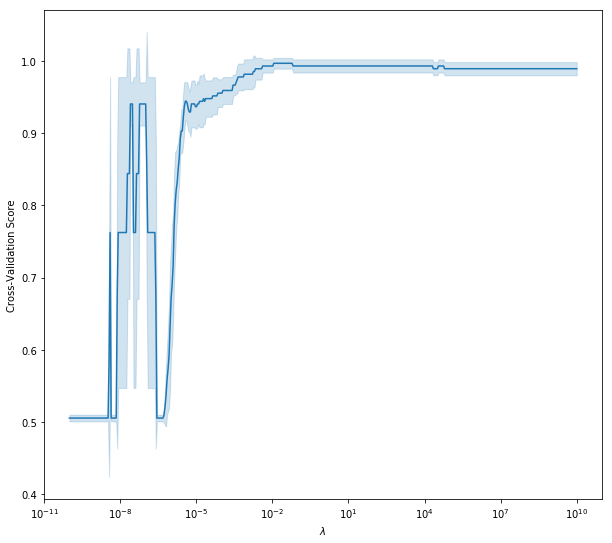

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt

x_train, x_test, y_train, y_test = train_test_split(bdata, labels, random_state=42069)

cs = np.logspace(-10, 10, 500)

mu, sig = [], []

for c in cs:
    lr = LogisticRegression(C=c, max_iter=1000)

    scores = cross_val_score(lr, x_train, y_train, cv=5)

    mu.append(np.mean(scores))
    sig.append(np.std(scores))

mu = np.asarray(mu)
sig = np.asarray(sig)

# prefer high score with low std
i = np.argmax(mu - sig)
c = cs[i]
print("optimal lambda:", c)

plt.figure(figsize=(10, 9))
plt.plot(cs, mu, color="C0")
plt.fill_between(cs, mu - sig, mu + sig, color="C0", alpha=0.2)
plt.xscale("log")
plt.xlabel(r"$\lambda$")
plt.ylabel("Cross-Validation Score")
plt.show()

In [4]:
lr = LogisticRegression(C=c, max_iter=1000)

lr.fit(x_train, y_train)

classified = lr.predict(x_test)

incorrect = classified != y_test

print("Error Rate:", np.mean(incorrect.astype(float)))



Error Rate: 0.0


### 1.2 Optimization Methods

<span style="color:green;font-weight:bold">
Comment: essentially the same. In 'predict' we used np.sign instead of manually setting to $\pm1$. This gives a different prediction for $X_i\cdot\beta=0$ (which is unlikely to happen anyway). In this case the instance will always be treated as misclassified, but this is ok since the instance would lie exactly on the decision plane.<br>
In 'zero_one_loss' we returned the number of misclassified instances without dividing by the total number, as asked in the exercise.
</span>

In [5]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

def gradient(beta, X, y, lambd):
    # beta.T/lambda + 1/N*sum_i(sigma(-y_i X_i beta)(-y_i X_i))
    return beta.T/lambd + 1/len(y) * (sigmoid(-y*X.dot(beta))[:,np.newaxis] * (-y[:,np.newaxis]*X)).sum(axis=0)
    
def predict(beta, X):
    return np.sign(X.dot(beta))

def zero_one_loss(y_prediction, y_truth):
    return (y_prediction != y_truth).sum()


<span style="color:green;font-weight:bold">
Comment: The methods are all implemented correctly. But we used different function signatures for every method which results in code for task 1.3 that is much harder to maintain, as can be seen in Cell 14-16.<br>
Also, calculating the training/test errors while updating $\beta$ is better. In 1.3.Speed we loop over the number of iterations and calculate the $\beta$ everytime, which is much slower.
</span>

In [6]:
def gradient_descent(X, y, T, lambd, beta_0, tau):
    beta = beta_0
    for t in range(T):
        beta = beta - tau*gradient(beta, X, y, lambd)
    return beta

def SG(X, y, T, lambd, gamma, beta_0, tau_0):
    beta = beta_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instance = [np.random.randint(len(y))]
        beta = beta - tau*gradient(beta, X[instance], y[instance], lambd)
    return beta
    
def SG_minibatch(X, y, T, lambd, gamma, B, beta_0, tau_0):
    beta = beta_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instances = np.random.choice(len(y), size=B, replace=False)
        beta = beta - tau*gradient(beta, X[instances], y[instances], lambd)
    return beta

def SG_momentum(X, y, T, lambd, gamma, mu, beta_0, g_0, tau_0):
    beta = beta_0
    g = g_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instance = [np.random.randint(len(y))]
        g = mu*g + (1-mu)*gradient(beta, X[instance], y[instance], lambd)
        beta = beta - tau*g
    return beta

def ADAM(X, y, T, lambd, gamma, mu_1, mu_2, beta_0, g_0, q_0, tau_0, epsilon):
    beta = beta_0
    g = g_0
    q = q_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instance = [np.random.randint(len(y))]
        l = gradient(beta, X[instance], y[instance], lambd)
        g = mu_1*g + (1-mu_1)*l
        q = mu_2*q + (1-mu_2)*(l*l)
        g_ = g/(1-mu_1**(t+1))
        q_ = q/(1-mu_2**(t+1))
        beta = beta - tau/(np.sqrt(q_)+epsilon)*g_
    return beta

def SG_average(X, y, T, gamma, beta_0, tau_0):
    beta = beta_0
    s = sigmoid(-y*X.dot(beta_0))
    g_stored = (-y*X.T*(sigmoid(-y*X.dot(beta_0)))).T
    g = 1/len(y)*g_stored.sum(axis=0)
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        i = np.random.randint(len(y))
        g_i = -y[i]*X[i].T*(sigmoid(-y[i]*X[i].dot(beta)))
        g = g + 1/len(y)*(g_i - g_stored[i])
        g_stored[i] = g_i
        beta = beta*(1 - tau/c) - tau*g
        
    return beta
    
def dual_coordinate_ascent(X, y, T, lambd, epsilon, alpha_0):
    N = len(y)
    alpha = alpha_0
    beta = lambd/N * ((alpha_0*y)[:,np.newaxis]*X).sum(axis=0)
    for t in range(T):
        i = np.random.randint(len(y))
        f_ = y[i]*X[i].dot(beta) + np.log(alpha[i]/(1-alpha[i]))
        f__ = lambd/N*X[i].dot(X[i]) + 1/(alpha[i]*(1-alpha[i]))
        alpha_new = np.clip(alpha - f_/f__, epsilon, 1-epsilon)
        beta = beta + lambd/N*(y*X.T*(alpha_new-alpha)).sum(axis=1)
        alpha = alpha_new
        
    return beta
        
def Newton_Raphson(X, y, T, lambd, beta_0):
    N = len(y)
    D = X.shape[1]
    beta = beta_0
    for t in range(T):
        z = X.dot(beta)
        y_ = y/sigmoid(y*z)
        sigmoid_z = sigmoid(z)
        W = np.diag(lambd/N*sigmoid_z*(1-sigmoid_z))
        beta = np.linalg.inv(np.eye(D) + X.T.dot(W).dot(X)).dot(X.T.dot(W).dot(z+y_))
        
    return beta


#### With or without replacement
For this exercise, it doesn't really make a difference wheter we sample with or without replacement. Both converge at the same speed and give the same error rate. Since one usually uses sampling without replacement for SG, we decided to use this version

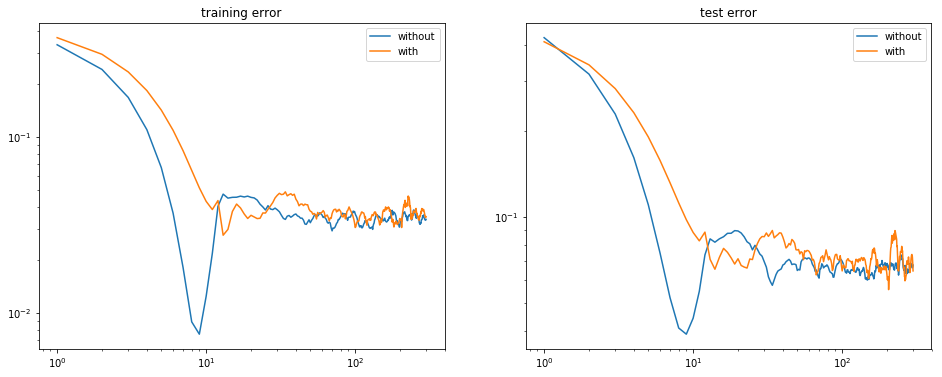

In [10]:
from scipy.signal import savgol_filter  # for smoothing

def SG_minibatch_with_replacement(X, y, T, lambd, gamma, B, beta_0, tau_0):
    beta = beta_0
    for t in range(T):
        tau = tau_0/(1+gamma*t)
        instances = np.random.choice(len(y), size=B, replace=True)
        beta = beta - tau*gradient(beta, X[instances], y[instances], lambd)
    return beta
        
X_train, X_test, y_train, y_test = train_test_split(bdata, labels, test_size=0.3)
N_train, D = X_train.shape
N_test, D = X_test.shape
beta_0 = np.zeros(D)

T_max = 300
training_errors_SGbatch = np.zeros((2, T_max))
test_errors_SGbatch = np.zeros((2, T_max))
for T in range(T_max):
    tau, gamma, B = 0.001, 0.001, 100
    
    beta = SG_minibatch(X_train, y_train, T, c, gamma, B, beta_0, tau)
    training_errors_SGbatch[0][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors_SGbatch[0][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    beta = SG_minibatch_with_replacement(X_train, y_train, T, c, gamma, B, beta_0, tau)
    training_errors_SGbatch[1][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors_SGbatch[1][T] = zero_one_loss(y_test, predict(beta, X_test))
    
training_errors_SGbatch /= N_train
test_errors_SGbatch /= N_test
    
fig, axes = plt.subplots(1, 2, figsize=(16,6))
T = np.arange(1,T_max)

axes[0].plot(T, savgol_filter(training_errors_SGbatch[0][1:], 21, 3), label="without")
axes[0].plot(T, savgol_filter(training_errors_SGbatch[1][1:], 21, 3), label="with")
axes[0].set_yscale('log')
axes[0].set_xscale('log')
axes[0].set_title("training error")
axes[0].legend()

axes[1].plot(T, savgol_filter(test_errors_SGbatch[0][1:], 21, 3), label="without")
axes[1].plot(T, savgol_filter(test_errors_SGbatch[1][1:], 21, 3), label="with")
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_title("test error")
axes[1].legend()

### 1.3 Comparison

<span style="color:green;font-weight:bold">
Comment: As mentioned above, the sample solution does this task in a better way.<br>
We added $\tau=0.0001$ since $\tau=0.1$ always resulted in a very high error rate.<br>
In ADAM we tried different values for $\tau, \gamma$ as well, since we weren't sure, if those are fixed.
</span>

In [14]:
from sklearn.model_selection import train_test_split, KFold

X, X_test, y, y_test = train_test_split(bdata, labels, test_size=0.3, random_state=0)
(N, D) = X_train.shape
beta_0 = np.zeros(D)
g_0 = np.zeros(D)
q_0 = np.zeros(D)

kf = KFold(n_splits=10, shuffle=True)

tau_parameters = [0.0001, 0.001, 0.01, 0.1]
mu_parameters = [0.1, 0.2, 0.5]
gamma_parameters = [0.0001, 0.001, 0.01]
epsilon_parameters = [1e-8, 1e-7, 1e-6]
batchsize_parameters = [25, 50, 75, 100]


# gradient descent
errors = []
parameters = []
for tau in tau_parameters:
    error = 0
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]

        beta = gradient_descent(X_train, y_train, 10, c, beta_0, tau)
        error += zero_one_loss(y_validation, predict(beta, X_validation))
        
    parameters.append(tau)
    errors.append(error)
print("\ngradient descent (tau)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")

# SG
errors = []
parameters = []
for tau in tau_parameters:
    for gamma in gamma_parameters:
        error = 0
        for train_index, validation_index in kf.split(X):
            X_train, X_validation = X[train_index], X[validation_index]
            y_train, y_validation = y[train_index], y[validation_index]

            beta = SG(X_train, y_train, 150, c, gamma, beta_0, tau)
            error += zero_one_loss(y_validation, predict(beta, X_validation))

        parameters.append((tau, gamma))
        errors.append(error)
        
print("\nSG (tau, gamma)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# SG minibatch
errors = []
parameters = []
for tau in tau_parameters:
    for gamma in gamma_parameters:
        for batchsize in batchsize_parameters:
            error = 0
            for train_index, validation_index in kf.split(X):
                X_train, X_validation = X[train_index], X[validation_index]
                y_train, y_validation = y[train_index], y[validation_index]

                beta = SG_minibatch(X_train, y_train, 150, c, gamma, batchsize, beta_0, tau)
                error += zero_one_loss(y_validation, predict(beta, X_validation))

            parameters.append((tau, gamma, batchsize))
            errors.append(error)
        
print("\nSG_minibatch (tau, gamma, batchsize)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# SG momentum
errors = []
parameters = []
for tau in tau_parameters:
    for mu in mu_parameters:
        for gamma in gamma_parameters:
            error = 0
            for train_index, validation_index in kf.split(X):
                X_train, X_validation = X[train_index], X[validation_index]
                y_train, y_validation = y[train_index], y[validation_index]

                beta = SG_momentum(X_train, y_train, 150, c, gamma, mu, beta_0, g_0, tau)
                error += zero_one_loss(y_validation, predict(beta, X_validation))

            parameters.append((tau, mu, gamma))
            errors.append(error)
        
print("\nSG_momentum (tau, mu, gamma)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# ADAM
errors = []
parameters = []
for tau in tau_parameters:
    for gamma in gamma_parameters:
        error = 0
        for train_index, validation_index in kf.split(X):
            X_train, X_validation = X[train_index], X[validation_index]
            y_train, y_validation = y[train_index], y[validation_index]

            beta = ADAM(X_train, y_train, 150, c, gamma, 0.9, 0.999, beta_0, g_0, q_0, tau, 1e-8)
            error += zero_one_loss(y_validation, predict(beta, X_validation))

        parameters.append((tau, gamma))
        errors.append(error)
        
print("\nADAM (tau, gamma)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# SG_average
errors = []
parameters = []
for tau in tau_parameters:
    error = 0
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]

        beta = SG_average(X_train, y_train, 150, c, beta_0, tau)
        error += zero_one_loss(y_validation, predict(beta, X_validation))

    parameters.append(tau)
    errors.append(error)
        
print("\nSG_average (tau)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# dual_coordinate_ascent
errors = []
parameters = []
for epsilon in epsilon_parameters:
    error = 0
    for train_index, validation_index in kf.split(X):
        X_train, X_validation = X[train_index], X[validation_index]
        y_train, y_validation = y[train_index], y[validation_index]

        alpha_0 = np.random.uniform(size=X_train.shape[0])

        beta = dual_coordinate_ascent(X_train, y_train, 150, c, epsilon, alpha_0)
        error += zero_one_loss(y_validation, predict(beta, X_validation))

    parameters.append(epsilon)
    errors.append(error)
        
print("\ndual_coordinate_ascent (epsilon)")
print(parameters)
print(errors)
print(f"best (error:{np.min(errors)}): {parameters[np.argmin(errors)]}")


# Newton_Raphson
errors = []
parameters = []
error = 0
for train_index, validation_index in kf.split(X):
    X_train, X_validation = X[train_index], X[validation_index]
    y_train, y_validation = y[train_index], y[validation_index]

    beta = Newton_Raphson(X_train, y_train, 10, c, beta_0)
    error += zero_one_loss(y_validation, predict(beta, X_validation))

errors.append(error)
        
print("\nNewton_Raphson (no hyperparameters)")
print(errors)


gradient descent (tau)
[0.0001, 0.001, 0.01, 0.1]
[16, 14, 106, 188]
best (error:14): 0.001

SG (tau, gamma)
[(0.0001, 0.0001), (0.0001, 0.001), (0.0001, 0.01), (0.001, 0.0001), (0.001, 0.001), (0.001, 0.01), (0.01, 0.0001), (0.01, 0.001), (0.01, 0.01), (0.1, 0.0001), (0.1, 0.001), (0.1, 0.01)]
[30, 29, 27, 66, 81, 59, 128, 129, 119, 119, 123, 118]
best (error:27): (0.0001, 0.01)

SG_minibatch (tau, gamma, batchsize)
[(0.0001, 0.0001, 25), (0.0001, 0.0001, 50), (0.0001, 0.0001, 75), (0.0001, 0.0001, 100), (0.0001, 0.001, 25), (0.0001, 0.001, 50), (0.0001, 0.001, 75), (0.0001, 0.001, 100), (0.0001, 0.01, 25), (0.0001, 0.01, 50), (0.0001, 0.01, 75), (0.0001, 0.01, 100), (0.001, 0.0001, 25), (0.001, 0.0001, 50), (0.001, 0.0001, 75), (0.001, 0.0001, 100), (0.001, 0.001, 25), (0.001, 0.001, 50), (0.001, 0.001, 75), (0.001, 0.001, 100), (0.001, 0.01, 25), (0.001, 0.01, 50), (0.001, 0.01, 75), (0.001, 0.01, 100), (0.01, 0.0001, 25), (0.01, 0.0001, 50), (0.01, 0.0001, 75), (0.01, 0.0001, 100)

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(bdata, labels, test_size=0.3, random_state=0)
errors = np.zeros(8)
for i in range(100):
    tau = 0.001
    beta = gradient_descent(X_train, y_train, 10, c, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[0] += error
    
    tau, gamma = 0.0001, 0.01
    beta = SG(X_train, y_train, 150, c, gamma, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[1] += error
    
    tau, gamma, B = 0.001, 0.001, 100
    beta = SG_minibatch(X_train, y_train, 150, c, gamma, B, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[2] += error

    tau, mu, gamma = 0.0001, 0.1, 0.0001
    beta = SG_momentum(X_train, y_train, 150, c, gamma, mu, beta_0, g_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[3] += error
    
    tau, gamma = 0.001, 0.01
    beta = ADAM(X_train, y_train, 150, c, gamma, 0.9, 0.999, beta_0, g_0, q_0, tau, 1e-8)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[4] += error
    
    tau = 0.0001
    beta = SG_average(X_train, y_train, 150, c, beta_0, tau)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[5] += error
    
    epsilon = 1e-08
    alpha_0 = np.random.uniform(size=X_train.shape[0])
    beta = dual_coordinate_ascent(X_train, y_train, 150, c, epsilon, alpha_0)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[6] += error
    
    beta = Newton_Raphson(X_train, y_train, 10, c, beta_0)
    error = zero_one_loss(y_test, predict(beta, X_test))
    errors[7] += error
    
print(errors/100)
                

### Speed
Newton-Raphson needs the least iterations to converge but due to the high complexity, it takes $T\approx10^6$ until convergence.
The stochastic gradient algorithms need more iterations, but only $T\approx10^4$ until convergence. The stochastic algorithms have
great noise in their final classification errors, while the others do not.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(bdata, labels, test_size=0.3, random_state=0)
N_train, D = X_train.shape
N_test, D = X_test.shape

T_max = 300
training_errors = np.zeros((8, T_max))
test_errors = np.zeros((8, T_max))
for T in range(T_max):
    if T % 100 == 0:
        print(T)
    tau = 0.001
    beta = gradient_descent(X_train, y_train, T, c, beta_0, tau)
    training_errors[0][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[0][T] = zero_one_loss(y_test, predict(beta, X_test))

    tau, gamma = 0.0001, 0.01
    beta = SG(X_train, y_train, T, c, gamma, beta_0, tau)
    training_errors[1][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[1][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    tau, gamma, B = 0.001, 0.001, 100
    beta = SG_minibatch(X_train, y_train, T, c, gamma, B, beta_0, tau)
    training_errors[2][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[2][T] = zero_one_loss(y_test, predict(beta, X_test))

    tau, mu, gamma = 0.0001, 0.1, 0.0001
    beta = SG_momentum(X_train, y_train, T, c, gamma, mu, beta_0, g_0, tau)
    training_errors[3][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[3][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    tau, gamma = 0.001, 0.01
    beta = ADAM(X_train, y_train, 150, c, gamma, 0.9, 0.999, beta_0, g_0, q_0, tau, 1e-8)
    training_errors[4][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[4][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    tau = 0.0001
    beta = SG_average(X_train, y_train, T, c, beta_0, tau)
    training_errors[5][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[5][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    epsilon = 1e-08
    alpha_0 = np.random.uniform(size=X_train.shape[0])
    beta = dual_coordinate_ascent(X_train, y_train, T, c, epsilon, alpha_0)
    training_errors[6][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[6][T] = zero_one_loss(y_test, predict(beta, X_test))
    
    beta = Newton_Raphson(X_train, y_train, T, c, beta_0)
    training_errors[7][T] = zero_one_loss(y_train, predict(beta, X_train))
    test_errors[7][T] = zero_one_loss(y_test, predict(beta, X_test))

    
training_errors /= N_train
test_errors /= N_test


0
100
200


<span style="color:green;font-weight:bold">
Comment: We used the same maximum number of iterations for every method which leads to differen x-axes for every plot. The plots in the sample solution have the same x-axes and are thus easier to interpret.<br>
Since some of the plots were very noisy, we used a filter for smoothing.
</span>

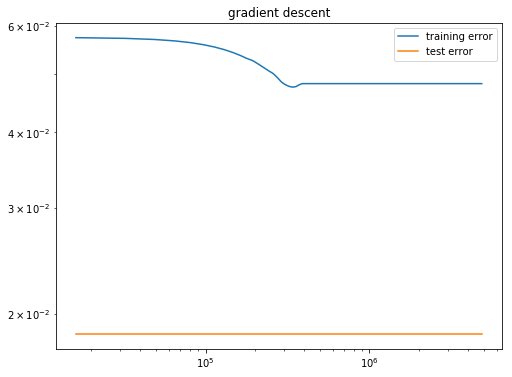

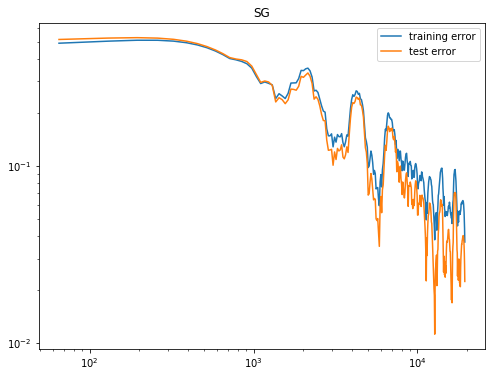

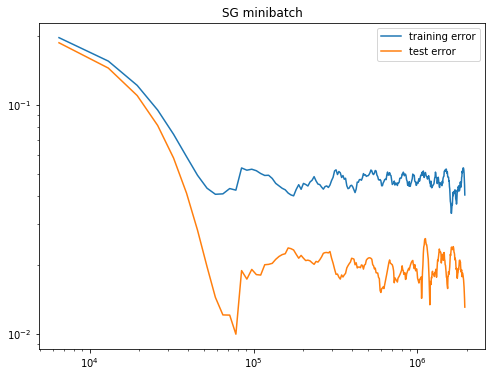

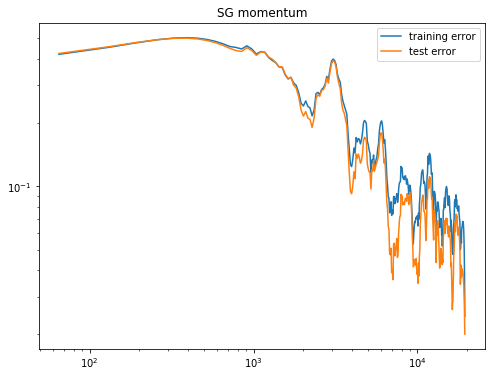

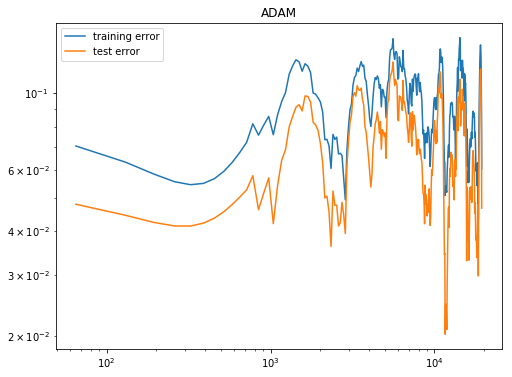

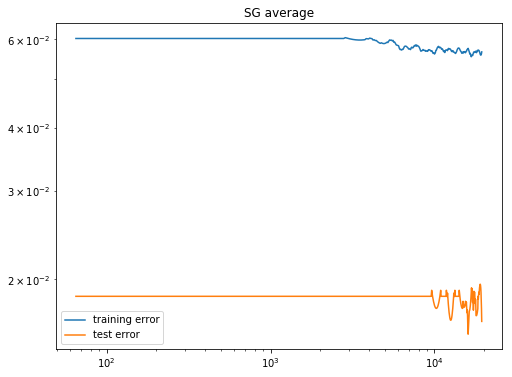

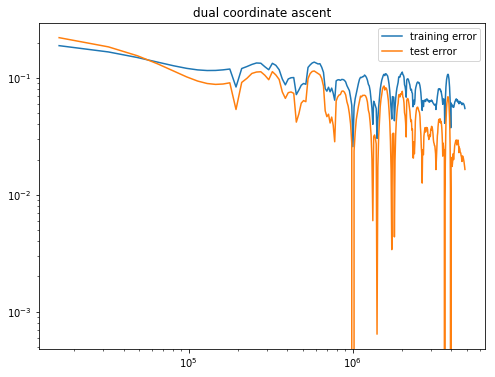

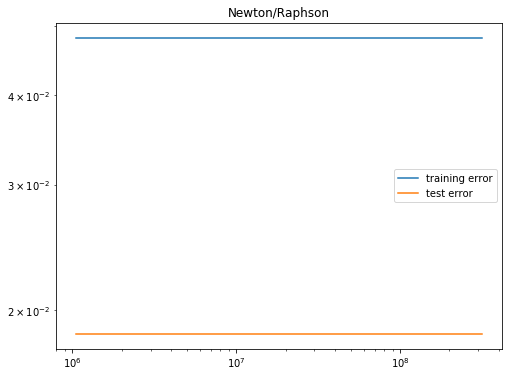

In [16]:
from scipy.signal import savgol_filter  # for smoothing

complexities = [N_train*D, D, B*D, D, D, D, N_train*D, N_train*D*D]
titles = ["gradient descent", "SG", "SG minibatch", "SG momentum", "ADAM", "SG average", "dual coordinate ascent", "Newton/Raphson"]

for i in range(8):
    plt.figure(figsize=(8,6))
    T = np.arange(1,T_max)*complexities[i]

    # smoothe the errors with a savgol filter
    # plots are very noisy otherwise
    train_err = savgol_filter(training_errors[i][1:], 21, 3)
    test_err = savgol_filter(test_errors[i][1:], 21, 3)

    # for smoothed plotting
    plt.plot(T, train_err, label="training error")
    plt.plot(T, test_err, label="test error")

    # for unsmoothed plotting
    # plt.plot(T, training_errors[i][1:], label="training error")
    # plt.plot(T, test_errors[i][1:], label="test error")

    plt.title(titles[i])
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()